In [3]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pyesg 
import  evaluation as eval
import preproccessing as prep 

In [4]:
acwi_prices = pd.read_excel('msci_acwi_net_30.10.23.xlsx')
acwi_prices.index = pd.DatetimeIndex(acwi_prices['Date'])
acwi_prices = acwi_prices['ACWI Standard Net (Large+Mid Cap)']
acwi_returns = prep.log_returns(acwi_prices)

<AxesSubplot:xlabel='Date'>

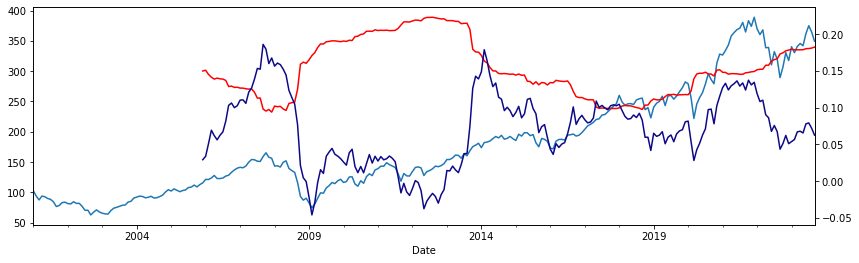

In [5]:
fig, ax1 = plt.subplots()
acwi_prices.plot(ax=ax1, figsize=(14,4))
ax2 = ax1.twinx()
(acwi_returns.rolling(60).std()*np.sqrt(12)).plot(ax=ax2, colormap='autumn')
(acwi_returns.rolling(60).mean()*12).plot(ax=ax2, colormap='plasma')

In [6]:
def asset_stats(returns, periods):
    summary = []

    for period in periods:
        summary.append(prep.assets_performance(acwi_returns[period[0]:period[1]]))

    return pd.DataFrame(data=summary, index=periods)

periods = [('2001-01-31', '2023-09-30'),
           ('2001-01-31', '2019-12-31'), 
           ('2000-08-31', '2023-07-31'),
           ('2003-03-31', '2020-03-31'),
           ('2003-03-31', '2022-12-31'),
           ('2009-02-28', '2022-12-31'),
           ('2007-10-31', '2022-12-31'),
           ('2007-10-31', '2015-05-30')
           ]


asset_stats(acwi_returns,periods)

,Annualised Mean,Annualised Sigma,Skew,Kurtosis,Sharp_ratio,Max drowdawn
"(2001-01-31, 2023-09-30)",0.055009,0.160995,-0.856140,2.121958,0.538119,-0.549231
"(2001-01-31, 2019-12-31)",0.054624,0.154934,-0.987229,2.835527,0.550549,-0.549231
"(2000-08-31, 2023-07-31)",0.058540,0.161136,-0.874261,2.159978,0.613556,-0.549231
"(2003-03-31, 2020-03-31)",0.072407,0.154143,-1.182134,3.763084,0.953037,-0.549231
"(2003-03-31, 2022-12-31)",0.080425,0.157982,-0.983730,2.908463,1.105673,-0.549231
"(2009-02-28, 2022-12-31)",0.104803,0.154169,-0.435559,0.801444,1.680774,-0.256253
"(2007-10-31, 2022-12-31)",0.045327,0.172403,-0.860163,2.140233,0.307968,-0.549231
"(2007-10-31, 2015-05-30)",0.028687,0.187189,-1.004988,2.562275,-0.024306,-0.549231


<AxesSubplot:xlabel='ACWI Standard Net (Large+Mid Cap)', ylabel='Probability'>

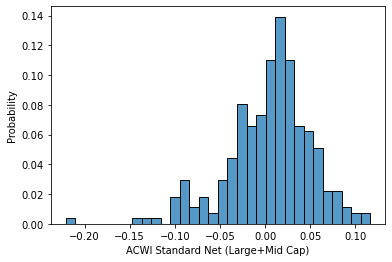

In [15]:
sns.histplot(data=acwi_returns, bins=32, stat='probability')

In [8]:
gbm_std = 0.155
gbm_mean = 0.5*gbm_std**2 + 0.072
gbm_mean

0.08401249999999999

In [9]:
number_of_scenarios = 50000
number_of_steps = 50
model = pyesg.GeometricBrownianMotion(mu=0.072,sigma=0.155)
scenarios = model.scenarios(349,1,number_of_scenarios,number_of_steps)
scenarios_df = pd.DataFrame(data=scenarios, index=range(0,number_of_scenarios), columns=range(0,number_of_steps+1))

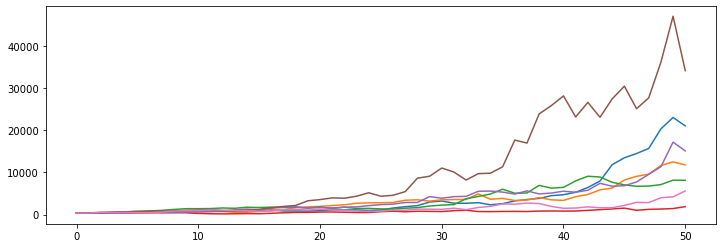

In [10]:
eval.sample_paths(scenarios,7)

,1,2,3,5,10,15,20,50
1,258.937657,238.614503,224.960420,209.765642,200.496933,212.207950,230.015316,542.800483
5,287.182532,274.877535,269.519467,267.297820,284.583362,318.714746,368.192414,1156.137017
25,333.762834,338.562023,348.476224,372.768945,456.763487,569.703233,720.289981,3311.334645
50,370.678413,393.040871,417.493466,470.549493,634.936144,855.322226,1155.006960,6978.089587
75,411.132540,456.243111,500.911601,594.539685,884.971463,1282.618096,1848.210925,14747.461768
95,477.232608,565.302069,648.386267,832.635703,1424.676025,2306.088872,3631.362046,43072.337321
99,528.934020,654.219446,772.788036,1048.439566,1967.840639,3424.026341,5891.434869,91411.186706


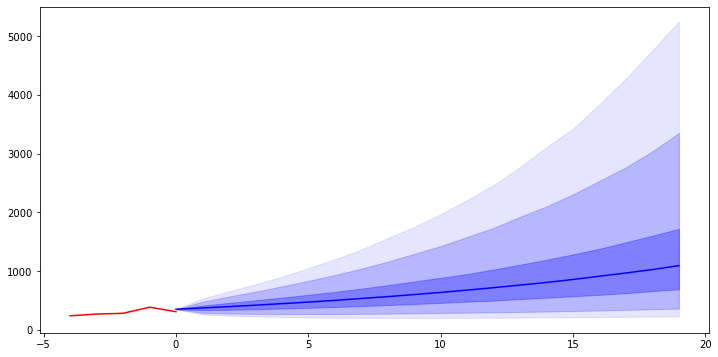

In [11]:
eval.fanchart(acwi_prices[-60::12],scenarios[:,:20])
eval.percentile_summary(scenarios_df)

In [12]:

scenarios_returns = prep.log_returns(scenarios_df.T)
eval.describe_scenarios_vertically(scenarios_returns, data_freq='y')

,Annualised Mean,Annualised Sigma,Skew,Kurtosis,Sharp_ratio,Max drowdawn
count,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,0.059987,0.154255,-0.001642,-0.002943,4.519778,-0.386647
std,0.022035,0.015668,0.336210,0.658263,1.803012,0.118496
min,-0.034912,0.091103,-1.833063,-1.405157,-2.809561,-0.924552
25%,0.045001,0.143532,-0.219044,-0.455224,3.285358,-0.459477
50%,0.059909,0.153913,-0.001555,-0.126496,4.468259,-0.371559
75%,0.074875,0.164758,0.215027,0.306141,5.704086,-0.299853
max,0.144821,0.220584,1.711369,7.275102,13.800154,-0.067452


<AxesSubplot:ylabel='Probability'>

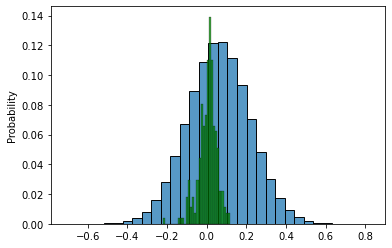

In [16]:
fig, ax1 = plt.subplots()
sns.histplot((scenarios_returns.to_numpy()).reshape(scenarios_returns.shape[0]*scenarios_returns.shape[1]),stat='probability', bins=32, ax=ax1)
sns.histplot((acwi_returns.to_numpy()),stat='probability', bins=32, ax=ax1, color='green')

In [17]:
from scipy.stats import invgamma
T = 60 #acwi_returns.shape[0]
mu = acwi_returns.mean()
B = (((acwi_returns - mu)**2).sum())*0.5
a = (T/2+1)
mean = B/(a-1)
s = invgamma.rvs(a, loc=mean,scale=B,size=100)**0.5 *np.sqrt(12)
